In [6]:
import os
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import itertools
import seaborn as sns

In [7]:
project_path = './'
image_size = (256, 256)  
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    os.path.join(project_path, 'archive/Training'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = datagen.flow_from_directory(
    os.path.join(project_path, 'archive/Testing'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [8]:
lenet5 = keras.Sequential([
    layers.Conv2D(6, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    layers.AveragePooling2D(),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(4, activation='softmax')  
])

lenet5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

alexnet = keras.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  
])

alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
inception_model = keras.Sequential([
    base_model_inception,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')  
])
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

inception_v4_model = timm.create_model('inception_v4', pretrained=True, num_classes=4)
optimizer_inception_v4 = optim.Adam(inception_v4_model.parameters(), lr=0.001)
criterion_inception_v4 = nn.CrossEntropyLoss()

def train_model(model, optimizer, criterion, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

In [9]:
epochs = 10

train_images = []
train_labels = []

for _ in range(len(train_data) // batch_size):
    batch_images, batch_labels = train_data.next()
    train_images.append(batch_images)
    train_labels.append(np.argmax(batch_labels, axis=1))

train_images = np.vstack(train_images)
train_labels = np.hstack(train_labels)

skf = StratifiedKFold(n_splits=10, shuffle=True)
fold = 1
accuracies_lenet5 = []
accuracies_alex = []
accuracies_inception = []
accuracies_inception_v4 = []

for train_index, val_index in skf.split(train_images, train_labels):
    train_fold_images, val_fold_images = train_images[train_index], train_images[val_index]
    train_fold_labels, val_fold_labels = train_labels[train_index], train_labels[val_index]

    train_fold_data = ImageDataGenerator().flow(train_fold_images, keras.utils.to_categorical(train_fold_labels),
                                                batch_size=batch_size)
    val_fold_data = ImageDataGenerator().flow(val_fold_images, keras.utils.to_categorical(val_fold_labels),
                                              batch_size=batch_size)

    history_lenet5 = lenet5.fit(train_fold_data, epochs=epochs, validation_data=val_fold_data, verbose= 0)
    acc_lenet5 = history_lenet5.history['val_accuracy'][-1]
    print(f'LeNet5 Fold: {fold}')
    accuracies_lenet5.append(acc_lenet5)
    
    history_alex = alexnet.fit(train_fold_data, epochs=epochs, validation_data=val_fold_data, verbose= 0)
    acc_alex = history_alex.history['val_accuracy'][-1]
    print(f'AlexNet Fold: {fold}')
    accuracies_alex.append(acc_alex)
    
    history_inception = inception_model.fit(train_fold_data, epochs=epochs, validation_data=val_fold_data, verbose=0)
    acc_inception = history_inception.history['val_accuracy'][-1]
    print(f'Inception-v3 Fold: {fold}')
    accuracies_inception.append(acc_inception)
    
    train_fold_loader = DataLoader(
        TensorDataset(torch.tensor(train_fold_images, dtype=torch.float32).permute(0, 3, 1, 2),
                      torch.tensor(train_fold_labels, dtype=torch.long)),
        batch_size=batch_size,
        shuffle=True
    )
    val_fold_loader = DataLoader(
        TensorDataset(torch.tensor(val_fold_images, dtype=torch.float32).permute(0, 3, 1, 2),
                      torch.tensor(val_fold_labels, dtype=torch.long)),
        batch_size=batch_size,
        shuffle=False
    )

    train_model(inception_v4_model, optimizer_inception_v4, criterion_inception_v4, train_fold_loader, epochs)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_fold_loader:
            outputs = inception_v4_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc_inception_v4 = correct / total
    print(f'Inception-v4 Fold {fold} Validation Accuracy: {acc_inception_v4:.2f}')
    accuracies_inception_v4.append(acc_inception_v4)
    fold += 1

print(f'Mean Validation Accuracy LeNet5: {np.mean(accuracies_lenet5)}')
print(f'Mean Validation Accuracy AlexNet: {np.mean(accuracies_alex)}')
print(f'Mean Validation Accuracy Inception-v3: {np.mean(accuracies_inception)}')
print(f'Mean Validation Accuracy Inception-v4: {np.mean(accuracies_inception_v4)}')

LeNet5 Fold: 1
AlexNet Fold: 1
Inception-v3 Fold: 1
Epoch 1/10, Loss: 0.975325083732605
Epoch 2/10, Loss: 0.5938038527965546
Epoch 3/10, Loss: 0.4992194175720215
Epoch 4/10, Loss: 0.18703514635562896
Epoch 5/10, Loss: 0.14036696255207062
Epoch 6/10, Loss: 0.1511798083782196
Epoch 7/10, Loss: 0.25624109879136087
Epoch 8/10, Loss: 0.29045611917972564
Epoch 9/10, Loss: 0.06784282401204109
Epoch 10/10, Loss: 0.23415105119347573
Inception-v4 Fold 1 Validation Accuracy: 1.00
LeNet5 Fold: 2
AlexNet Fold: 2
Inception-v3 Fold: 2
Epoch 1/10, Loss: 0.1662097755819559
Epoch 2/10, Loss: 0.08149634208530188
Epoch 3/10, Loss: 0.08399877175688744
Epoch 4/10, Loss: 0.034587109088897706
Epoch 5/10, Loss: 0.05118881007656455
Epoch 6/10, Loss: 0.126320712082088
Epoch 7/10, Loss: 0.16243221051990986
Epoch 8/10, Loss: 0.13434570673853158
Epoch 9/10, Loss: 0.09534366317093372
Epoch 10/10, Loss: 0.03251201137900352
Inception-v4 Fold 2 Validation Accuracy: 0.88
LeNet5 Fold: 3
AlexNet Fold: 3
Inception-v3 Fold:

Testing LeNet5:
1/1 [==============================] - 0s 296ms/step
              precision    recall  f1-score   support

      glioma       0.61      0.59      0.60       300
  meningioma       0.44      0.32      0.37       306
     notumor       0.75      0.84      0.79       405
   pituitary       0.66      0.76      0.71       300

    accuracy                           0.64      1311
   macro avg       0.62      0.63      0.62      1311
weighted avg       0.63      0.64      0.63      1311



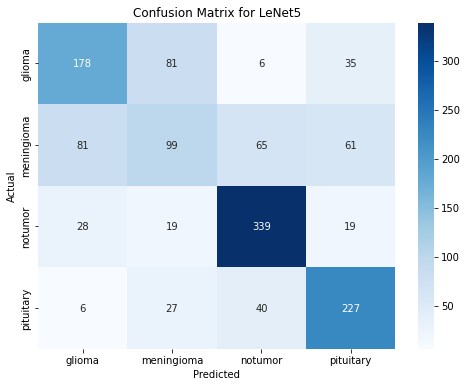

Testing AlexNet:
1/1 [==============================] - 0s 301ms/step
              precision    recall  f1-score   support

      glioma       0.68      0.72      0.70       300
  meningioma       0.56      0.40      0.47       306
     notumor       0.80      0.79      0.80       405
   pituitary       0.70      0.88      0.78       300

    accuracy                           0.70      1311
   macro avg       0.69      0.70      0.69      1311
weighted avg       0.69      0.70      0.69      1311



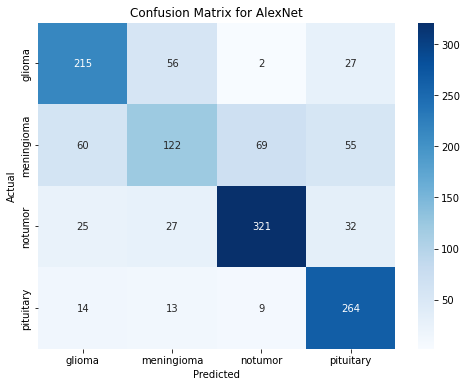

Testing Inception-v3:
1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

      glioma       0.57      0.93      0.71       300
  meningioma       0.46      0.76      0.58       306
     notumor       0.96      0.62      0.75       405
   pituitary       0.96      0.18      0.31       300

    accuracy                           0.63      1311
   macro avg       0.74      0.63      0.59      1311
weighted avg       0.76      0.63      0.60      1311



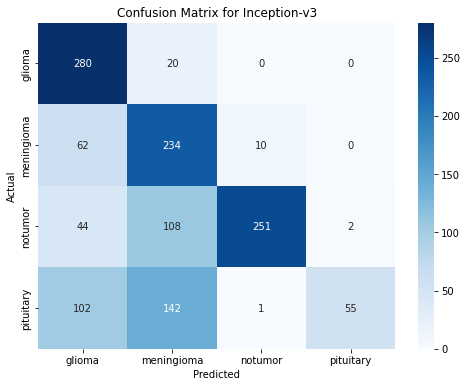

              precision    recall  f1-score   support

      glioma       0.85      0.63      0.72       300
  meningioma       0.79      0.59      0.68       306
     notumor       0.90      0.92      0.91       405
   pituitary       0.66      0.97      0.78       300

    accuracy                           0.79      1311
   macro avg       0.80      0.78      0.77      1311
weighted avg       0.80      0.79      0.78      1311



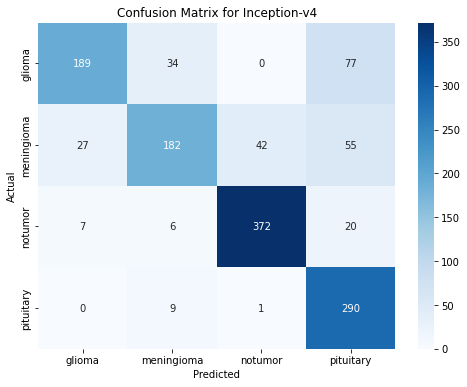

In [10]:
def test_models(models, test_data):
    for model_name, model in models.items():
        print(f"Testing {model_name}:")
        all_predictions = []
        true_labels = []
        batch_size = test_data.batch_size
        num_batches = len(test_data)
        for i in range(num_batches):
            batch_images, batch_labels = test_data[i]
            predictions = model.predict(batch_images)
            all_predictions.extend(np.argmax(predictions, axis=1))
            true_labels.extend(np.argmax(batch_labels, axis=1))
        
        print(classification_report(true_labels, all_predictions, target_names=test_data.class_indices.keys()))

        cm = confusion_matrix(true_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), 
                    yticklabels=test_data.class_indices.keys())
        plt.title(f"Confusion Matrix for {model_name}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

models = {"LeNet5": lenet5, "AlexNet": alexnet, "Inception-v3": inception_model}
test_models(models, test_data)

def test_model_inception_v4(model, test_loader, class_names):
    model.eval()
    all_predictions = []
    true_labels = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    print(classification_report(true_labels, all_predictions, target_names=class_names))

    cm = confusion_matrix(true_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix for Inception-v4")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

test_images = []
test_labels = []

for _ in range(len(test_data)):
    batch_images, batch_labels = test_data.next()
    test_images.append(batch_images)
    test_labels.append(np.argmax(batch_labels, axis=1))

test_images = np.vstack(test_images)
test_labels = np.hstack(test_labels)

test_dataset = TensorDataset(torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2), 
                             torch.tensor(test_labels, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_model_inception_v4(inception_v4_model, test_loader, class_names)